In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    import pandas as pd
import numpy as np
import os
import gc
import io
import warnings
import cv2 as cv
from Utils import * 

warnings.filterwarnings("ignore")

df = pd.read_csv('heart_failure_raw.csv')

# Pytorch

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tfrecord.torch.dataset import TFRecordDataset

import torchxrayvision as xrv
import torchvision
from torchvision import models, datasets

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:4096"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


# Test on specific demographic group

In [3]:
tfrecord_path = "HF_test.tfrecords"
index_path = None
description = {"jpg_bytes": "byte", "Label": "int", "Race": "int", "Age": "int", "Gender": "int"}
test_dataset = TFRecordDataset(tfrecord_path, index_path = None, description = description, transform = data_transform['original'])
test_loader = torch.utils.data.DataLoader(test_dataset)

In [4]:
# ['MobileNetV3', 'EfficientNetV2', 'ResNet18', 'RegNet', 'ShuffleNetV2', 'MNASNet']

In [5]:
import matplotlib.pyplot as plt

races = []
ages = []
genders = []

y_preds = [[] for j in range(5)]

y_test = []
X_test = []

models = []

sigmoid = torch.nn.Sigmoid()

archi = 'DenseNet121_chex'

for rounds in range(5):
    models.append(define_model(archi))

    models[rounds].load_state_dict(torch.load('pytorch_checkpoints/{}/{}_{}_wfish_strong'.format(archi, archi, rounds), map_location=device))
    models[rounds].to(device)

    models[rounds].eval()


with torch.no_grad():
    for i, tdata in enumerate(test_loader):
        tinputs, tlabels, traces, tages, tgenders = tdata['jpg_bytes'], tdata['Label'], tdata['Race'], tdata['Age'], tdata['Gender']

        tinputs = tinputs.float().to(device)
        tlabels = tlabels.float().to(device)
        
        
        y_test.append(tlabels.item())
        races.append(traces.item())
        ages.append(tages.item())
        genders.append(tgenders.item())

        for i in range(5):
            toutputs = sigmoid(models[i](tinputs))
            y_preds[i].append(toutputs.item())

In [7]:
y_preds = np.array(y_preds)
y_test = np.array(y_test)
races = np.array(races)
ages = np.array(ages)
genders = np.array(genders)

## Overall

AUC : 0.67, CI: [0.64 - 0.69]
ACC : 0.62, CI: [0.56 - 0.68]
F1 score : 0.62, CI: [0.57 - 0.67]
Thresh: 0.6514074802398682


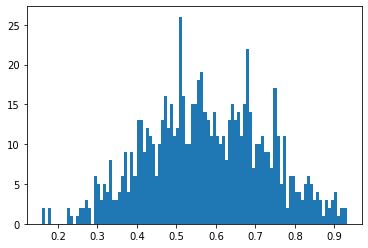

In [8]:
auc4amodel = []
acc4amodel = []
f14amodel = []

for i in range(5):

    fpr, tpr, threshes = metrics.roc_curve(y_test,  y_preds[i])

    best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

    auc4amodel.append(metrics.auc(fpr, tpr))

    best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

    acc4amodel.append(metrics.accuracy_score(y_test,  np.where(y_preds[i] >= best_thresh, 1, 0)))

    f14amodel.append(metrics.f1_score(y_test,  np.where(y_preds[i] >= best_thresh, 1, 0), average='weighted'))

get_CI('AUC', auc4amodel)
get_CI('ACC', acc4amodel)
get_CI('F1 score', f14amodel)

print('Thresh:', best_thresh)
plt.hist(np.mean(y_preds, axis=0), bins=100)
plt.show()

## Race

WHITE
524
AUC : 0.66, CI: [0.63 - 0.68]
ACC : 0.62, CI: [0.55 - 0.68]
F1 score : 0.61, CI: [0.55 - 0.68]


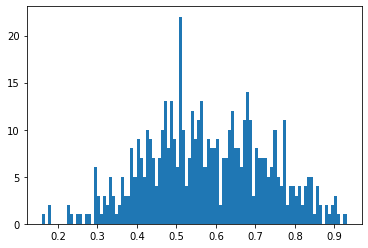

----------------------------
BLACK/AFRICAN AMERICAN
137
AUC : 0.71, CI: [0.69 - 0.73]
ACC : 0.69, CI: [0.58 - 0.81]
F1 score : 0.70, CI: [0.58 - 0.81]


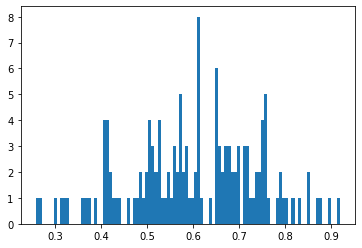

----------------------------
HISPANIC/LATINO
45
AUC : 0.73, CI: [0.62 - 0.84]
ACC : 0.74, CI: [0.67 - 0.82]
F1 score : 0.73, CI: [0.64 - 0.82]


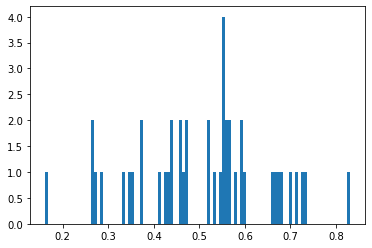

----------------------------
OTHER
42
AUC : 0.52, CI: [0.48 - 0.55]
ACC : 0.56, CI: [0.46 - 0.65]
F1 score : 0.55, CI: [0.42 - 0.68]


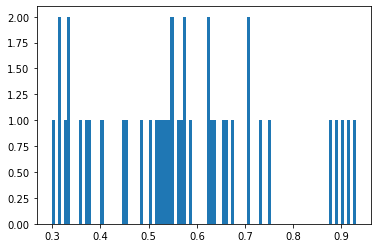

----------------------------
ASIAN
21
AUC : 0.70, CI: [0.61 - 0.80]
ACC : 0.71, CI: [0.62 - 0.81]
F1 score : 0.71, CI: [0.60 - 0.81]


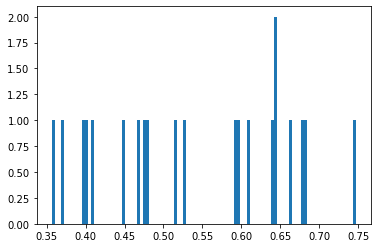

----------------------------


In [9]:
race_list = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'OTHER', 'ASIAN']

for group in np.unique(races):
    
    print(race_list[group])
    
    idx = np.where(races == group)[0]
    print(len(idx))
    
    auc4amodel = []
    acc4amodel = []
    f14amodel = []

    for i in range(5):
    
        fpr, tpr, threshes = metrics.roc_curve(y_test[idx],  y_preds[i, idx])

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
        
        auc4amodel.append(metrics.auc(fpr, tpr))

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

        acc4amodel.append(metrics.accuracy_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0)))

        f14amodel.append(metrics.f1_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0), average='weighted'))
        
    get_CI('AUC', auc4amodel)
    get_CI('ACC', acc4amodel)
    get_CI('F1 score', f14amodel)
    
    plt.hist(np.mean(y_preds, axis=0)[idx], bins=100)
    plt.show()

    print('----------------------------')

## Age

0-65
244
AUC : 0.73, CI: [0.70 - 0.76]
ACC : 0.70, CI: [0.66 - 0.74]
F1 score : 0.70, CI: [0.65 - 0.74]


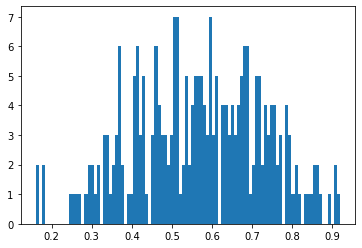

----------------------------
65-80
271
AUC : 0.65, CI: [0.58 - 0.71]
ACC : 0.61, CI: [0.52 - 0.69]
F1 score : 0.60, CI: [0.51 - 0.69]


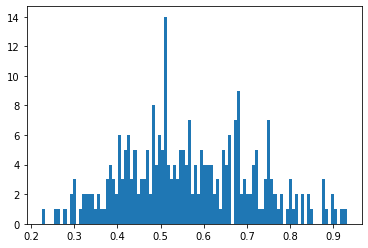

----------------------------
80+
254
AUC : 0.61, CI: [0.59 - 0.64]
ACC : 0.57, CI: [0.51 - 0.64]
F1 score : 0.58, CI: [0.52 - 0.65]


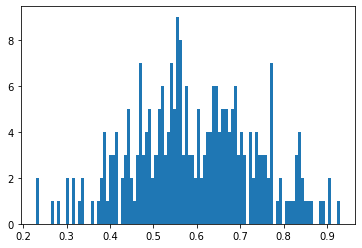

----------------------------


In [10]:
age_list = ['0-65', '65-80', '80+']

for group in np.unique(ages):
    
    print(age_list[group])
    
    idx = np.where(ages == group)[0]
    print(len(idx))
    
    auc4amodel = []
    acc4amodel = []
    f14amodel = []

    for i in range(5):

    
        fpr, tpr, threshes = metrics.roc_curve(y_test[idx],  y_preds[i, idx])

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
        
        auc4amodel.append(metrics.auc(fpr, tpr))

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

        acc4amodel.append(metrics.accuracy_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0)))

        f14amodel.append(metrics.f1_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0), average='weighted'))
        
    get_CI('AUC', auc4amodel)
    get_CI('ACC', acc4amodel)
    get_CI('F1 score', f14amodel)
    
    plt.hist(np.mean(y_preds, axis=0)[idx], bins=100)
    plt.show()

    print('----------------------------')

## Gender

Male
380
AUC : 0.63, CI: [0.58 - 0.67]
ACC : 0.61, CI: [0.56 - 0.66]
F1 score : 0.60, CI: [0.54 - 0.65]


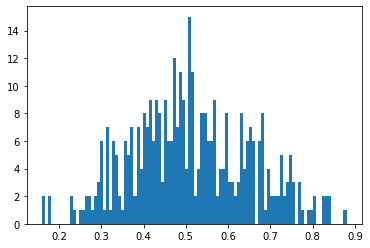

----------------------------
Female
389
AUC : 0.64, CI: [0.61 - 0.66]
ACC : 0.65, CI: [0.50 - 0.80]
F1 score : 0.64, CI: [0.53 - 0.76]


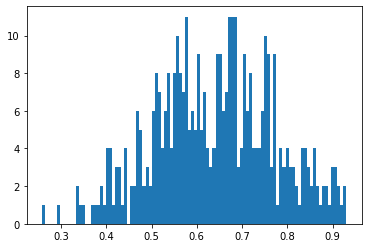

----------------------------


In [12]:
gender_list = ['Male', 'Female']

for group in np.unique(genders):
    
    print(gender_list[group])
    
    idx = np.where(genders == group)[0]
    
    print(len(idx))
    
    auc4amodel = []
    acc4amodel = []
    f14amodel = []

    for i in range(5):

    
        fpr, tpr, threshes = metrics.roc_curve(y_test[idx],  y_preds[i, idx])

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
        
        auc4amodel.append(metrics.auc(fpr, tpr))

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

        acc4amodel.append(metrics.accuracy_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0)))

        f14amodel.append(metrics.f1_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0), average='weighted'))
        
    get_CI('AUC', auc4amodel)
    get_CI('ACC', acc4amodel)
    get_CI('F1 score', f14amodel)
    
    plt.hist(np.mean(y_preds, axis=0)[idx], bins=100)
    plt.show()

    print('----------------------------')